In [2]:
import os
import json
import cv2
import re
import torch
import clip
from PIL import Image
import torchvision.transforms as transforms

# Load CLIP model and preprocessing function
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define directories
data_dir = "data"
videos_dir = os.path.join(data_dir, "videos")
captions_dir = os.path.join(data_dir, "captions")

# Function to extract YouTube video ID from filename
def extract_video_id(filename):
    match = re.search(r"\[([A-Za-z0-9_-]+)\]", filename)  # Extracts text inside brackets [videoID]
    return match.group(1) if match else None

# Get first available video file
video_files = [f for f in os.listdir(videos_dir) if f.endswith(".mp4")]
if not video_files:
    print("No video files found!")
    exit()

video_file = video_files[0]  # Grab the first video
video_path = os.path.join(videos_dir, video_file)

# Find corresponding caption file
video_id = extract_video_id(video_file)
if not video_id:
    print(f"Could not extract video ID from {video_file}")
    exit()

caption_file = next((f for f in os.listdir(captions_dir) if video_id in f and f.endswith(".json")), None)
if not caption_file:
    print(f"No matching caption file found for {video_file}")
    exit()

caption_path = os.path.join(captions_dir, caption_file)

# Load the caption JSON
with open(caption_path, "r", encoding="utf-8") as f:
    captions = json.load(f)

# Grab the first timestamp and its frames
if not captions:
    print("Caption file is empty!")
    exit()

first_entry = captions[0]
start_time = first_entry["start_time"]
end_time = first_entry["end_time"]
caption_text = first_entry["caption"]
frame_indices = first_entry.get("frames", [])

if not frame_indices:
    print("No frame indices found in the first caption entry!")
    exit()

print(f"\nSanity Check: {video_file}")
print(f"Caption: \"{caption_text}\"")
print(f"Timestamp: {start_time} → {end_time}")
print(f"Frame Indices: {frame_indices}")

# Extract frames and convert them into tensors
cap = cv2.VideoCapture(video_path)
frame_tensors = []

for frame_idx in frame_indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    
    if ret:
        # Convert BGR (OpenCV) to RGB (PIL)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)
        
        # Apply CLIP preprocessing
        frame_tensor = preprocess(pil_image).unsqueeze(0).to(device)  # Add batch dimension
        frame_tensors.append(frame_tensor)
    else:
        print(f"❌ Failed to retrieve frame {frame_idx}")

cap.release()

# Stack frames into a single tensor (batch)
if frame_tensors:
    frames_tensor = torch.cat(frame_tensors, dim=0)
    print(f"Frames tensor shape: {frames_tensor.shape}")  # (batch_size, 3, 224, 224)
else:
    print("❌ No valid frames were processed.")



Sanity Check: Cal Poly Survivor： S3 E10： Loved Ones [Kggc-m8ntVQ].mp4
Caption: "previously on C paully"
Timestamp: 00:00:00,359 → 00:00:02,350
Frame Indices: [10, 25, 40, 55, 70]
Frames tensor shape: torch.Size([5, 3, 224, 224])


In [ ]:
# Initialize lists to store frames and corresponding captions
all_frames = []
all_captions = []

# Loop through all video files
for video_file in video_files:
    video_path = os.path.join(videos_dir, video_file)
    video_id = extract_video_id(video_file)

    if not video_id:
        print(f"❌ Could not extract video ID from {video_file}")
        continue

    # Find matching caption file
    caption_file = next((f for f in os.listdir(captions_dir) if video_id in f and f.endswith(".json")), None)
    if not caption_file:
        print(f"❌ No matching caption file found for {video_file}")
        continue

    caption_path = os.path.join(captions_dir, caption_file)

    # Load caption JSON
    with open(caption_path, "r", encoding="utf-8") as f:
        captions = json.load(f)

    if not captions:
        print(f"❌ Caption file is empty for {video_file}")
        continue

    # Open video file
    cap = cv2.VideoCapture(video_path)

    # Process all caption entries
    for entry in captions:
        start_time = entry["start_time"]
        # print(f"Parsing caption starting at {start_time}")
        end_time = entry["end_time"]
        caption_text = entry["caption"]
        frame_indices = entry.get("frames", [])

        if not frame_indices:
            print(f"⚠️ No frame indices found for caption: \"{caption_text}\" in {video_file}")
            continue

        frame_tensors = []
        
        # Extract frames
        for frame_idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            
            if ret:
                frame_resized = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_AREA)  # Resize early
                frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(frame_rgb)
                frame_tensor = preprocess(pil_image).unsqueeze(0).to(device)
                frame_tensors.append(frame_tensor)
            else:
                print(f"❌ Failed to retrieve frame {frame_idx} in {video_file}")

        # Stack frames into a tensor (if valid frames exist)
        if frame_tensors:
            frames_tensor = torch.cat(frame_tensors, dim=0)  # Shape: (num_frames, 3, 224, 224)
            all_frames.append(frames_tensor)
            all_captions.append(caption_text)

    cap.release()
    # break

# Final dataset info
print(f"\n✅ Processed {len(all_frames)} captioned frame sequences")


Parsing caption starting at 00:00:00,359
Parsing caption starting at 00:00:02,360
Parsing caption starting at 00:00:14,440
Parsing caption starting at 00:00:36,910
Parsing caption starting at 00:01:00,640
Parsing caption starting at 00:01:51,920
Parsing caption starting at 00:01:54,280
Parsing caption starting at 00:01:57,719
Parsing caption starting at 00:02:00,479
Parsing caption starting at 00:02:03,759
Parsing caption starting at 00:02:06,640
Parsing caption starting at 00:02:09,200
Parsing caption starting at 00:02:11,720
Parsing caption starting at 00:02:15,040
Parsing caption starting at 00:02:17,800
Parsing caption starting at 00:02:21,160
Parsing caption starting at 00:02:24,120
Parsing caption starting at 00:02:26,760
Parsing caption starting at 00:02:30,120
Parsing caption starting at 00:02:32,519
Parsing caption starting at 00:02:35,040
Parsing caption starting at 00:02:36,879
Parsing caption starting at 00:02:38,560
Parsing caption starting at 00:02:42,319
Parsing caption 

In [ ]:
print(f"Total sequences collected: {len(all_frames)}")
print(f"Total captions collected: {len(all_captions)}")
# for i, frames_tensor in enumerate(all_frames):
#     print(f"Sequence {i}: {frames_tensor.shape}, Caption: {all_captions[i]}")

Total sequences collected: 1438
Total captions collected: 1438
Sequence 0: torch.Size([5, 3, 224, 224]), Caption: previously on C paully
Sequence 1: torch.Size([5, 3, 224, 224]), Caption: previously on C paully
Sequence 2: torch.Size([5, 3, 224, 224]), Caption: survived third unfortunately that's enough
Sequence 3: torch.Size([5, 3, 224, 224]), Caption: what
Sequence 4: torch.Size([5, 3, 224, 224]), Caption: something
Sequence 5: torch.Size([5, 3, 224, 224]), Caption: the last Tribal Council was pretty crazy I felt my heart beating so fast because
Sequence 6: torch.Size([5, 3, 224, 224]), Caption: I felt my heart beating so fast because it was one vote Jada one vote Tim two
Sequence 7: torch.Size([5, 3, 224, 224]), Caption: it was one vote Jada one vote Tim two votes Jada and so on so
Sequence 8: torch.Size([5, 3, 224, 224]), Caption: votes Jada and so on so yeah I was so scared but I was also
Sequence 9: torch.Size([5, 3, 224, 224]), Caption: yeah I was so scared but I was also expect

# **Dataset Class**


In [21]:
from torch.utils.data import Dataset, DataLoader
import random
class FrameCaptionDataset(Dataset):
    def __init__(self, frames, captions, tokenizer, seq_len=77, device='cpu'):
        """
        Args:
            frames: list of frame tensors
            captions: list of caption strings
            tokenizer: the tokenizer function (clip.tokenize)
            seq_len: desired sequence length for captions (CLIP uses a default max length of 77)
            device: the device to load tensors onto
        """
        self.frames = frames
        self.captions = captions
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.device = device

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        """ Return a randomly selected frame and the corresponding tokenized caption """
        # Select a random frame from the 5 frames
        frame_sequence = self.frames[idx]
        random_frame_idx = random.randint(0, len(frame_sequence) - 1)
        selected_frame = frame_sequence[random_frame_idx].to(self.device)  # Shape: (3, 224, 224)

        # Tokenize the caption and truncate/pad
        tokens = self.tokenizer([self.captions[idx]])[0]  # Tokenized caption
        tokens = tokens[:self.seq_len]  # Truncate to desired length (CLIP default is 77 tokens)
        
        # If the length is shorter than seq_len, left pad with 0s
        if len(tokens) < self.seq_len:
            tokens =  [0] * (self.seq_len - len(tokens)) + tokens
        
        tokens = torch.tensor(tokens, dtype=torch.long, device=self.device)

        return selected_frame, tokens


In [26]:
frameDataset = FrameCaptionDataset(all_frames,all_captions,clip.tokenize)
print(f"Frame shape: {frameDataset[210][0].shape}")
print(f"Caption shape: {frameDataset[210][1].shape}")


Frame shape: torch.Size([3, 224, 224])
Caption shape: torch.Size([77])


C:\Users\Scott\AppData\Local\Temp\ipykernel_24136\2508668625.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens = torch.tensor(tokens, dtype=torch.long, device=self.device)


C:\Users\Scott\AppData\Local\Temp\ipykernel_24136\2508668625.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens = torch.tensor(tokens, dtype=torch.long, device=self.device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6020194..1.9998449].


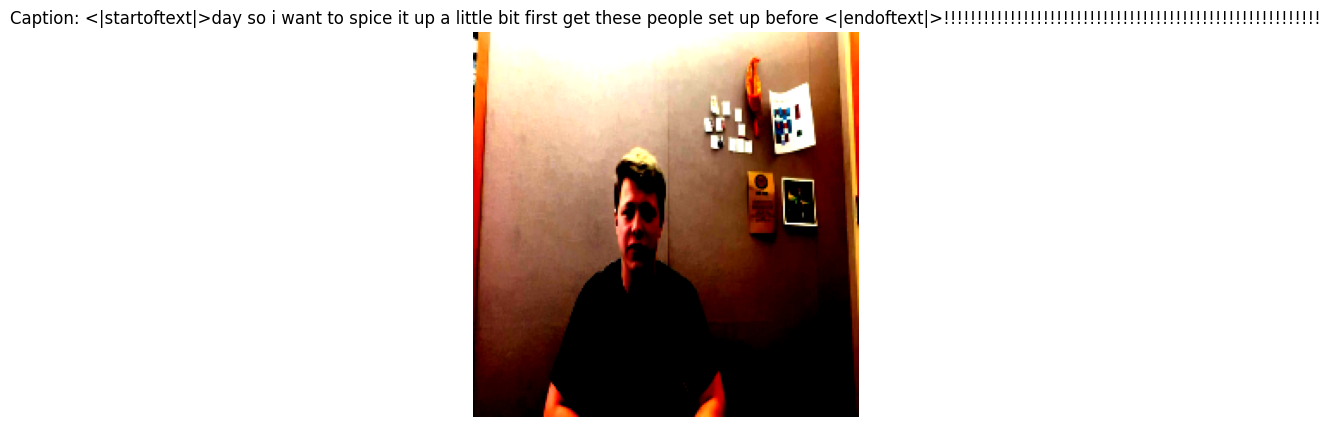

In [34]:
from transformers import CLIPProcessor
import matplotlib.pyplot as plt
# Initialize the processor (if not already done)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
frame_tensor = frameDataset[200][0]
# Get the tokenized caption
caption_tokens = frameDataset[200][1]

# Decode the caption tokens back into text
caption_text = processor.decode(caption_tokens)

# Plotting the selected frame
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust the size of the figure
frame_np = frame_tensor.cpu().numpy().transpose(1, 2, 0)  # Convert to (224, 224, 3)
ax.imshow(frame_np)
ax.axis("off")
ax.set_title(f"Caption: {caption_text}")  # Display the decoded caption

plt.show()


In [ ]:
import torch.nn.functional as F
import torch.optim as optim

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-6)  # Small LR to fine-tune

num_epochs = 10
frames_tensor = frames_tensor.to(device)  # Move all frames to device once
captions_tokenized = clip.tokenize([caption_text] * frames_tensor.shape[0]).to(device)  # Repeat caption

# Fine-tuning loop
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Reset gradients

    # Encode all images and text in a single batch
    image_features = model.encode_image(frames_tensor)
    text_features = model.encode_text(captions_tokenized)

    # Normalize
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)

    # Contrastive loss (maximize similarity)
    #TODO add contrastive loss as this was mentioned in the github for this model
    loss = -F.cosine_similarity(image_features, text_features).mean()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}")


Epoch 1/10 - Loss: -0.6126
Epoch 2/10 - Loss: -0.6434
Epoch 3/10 - Loss: -0.6847
Epoch 4/10 - Loss: -0.7088
Epoch 5/10 - Loss: -0.7417
Epoch 6/10 - Loss: -0.7683
Epoch 7/10 - Loss: -0.7877
Epoch 8/10 - Loss: -0.8100
Epoch 9/10 - Loss: -0.8290
Epoch 10/10 - Loss: -0.8451


# **TODO:**
(in no particular order)
1. Create Dataloader
2. Implement Contrastive Loss
3. Rework fine-tuning training loop (potentially freeze earlier layers of model)
